In [1]:
%pip install pandas numpy seaborn tensorflow
%pip install nltk
%pip install lime

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from lime import lime_text
from sklearn.pipeline import make_pipeline
from tensorflow.keras import backend as K  # Importar backend do Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Layer

# Camada de Atenção (Mover para antes da definição do modelo)
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight(name='att_W', shape=(input_shape[-1], 1), initializer='normal', trainable=True)
        self.b = self.add_weight(name='att_b', shape=(input_shape[1], 1), initializer='zeros', trainable=True)
        self.u = self.add_weight(name='att_u', shape=(input_shape[1], 1), initializer='normal', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = K.squeeze(K.tanh(K.dot(x, self.W) + self.b), axis=-1)
        at = K.softmax(et, axis=1)
        at = K.expand_dims(at, axis=-1)
        output = x * at
        output = K.sum(output, axis=1)
        self.attention_weights = at  # Armazenar os pesos para visualização
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        config = super().get_config().copy()
        return config

In [3]:
df = pd.read_csv('../spam.csv')

In [4]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.shape

(5572, 2)

<Axes: xlabel='Category', ylabel='count'>

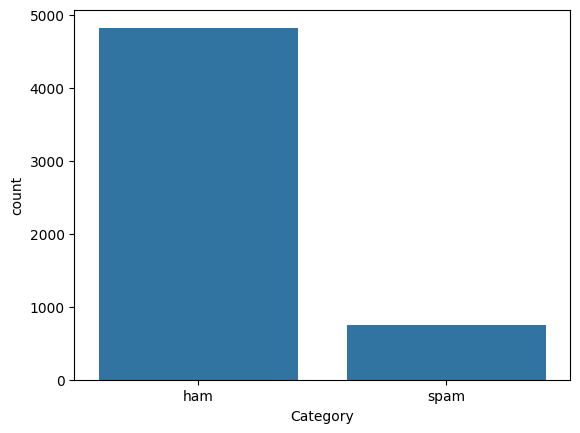

In [7]:
sns.countplot(x= 'Category', data = df)

**Pré-Processamento**

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Baixar pacotes necessários do NLTK
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('punkt_tab') # Download the 'punkt_tab' resource

[nltk_data] Downloading package stopwords to C:\Users\LUIRYS
[nltk_data]     SILVA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\LUIRYS
[nltk_data]     SILVA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\LUIRYS
[nltk_data]     SILVA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\LUIRYS
[nltk_data]     SILVA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [9]:
def preprocess_text(text):
    # Converter para minúsculas
    text = text.lower()

    # Remover caracteres especiais e números
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Tokenização (dividir em palavras)
    tokens = word_tokenize(text)

    # Remover stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    # Lematização (reduzir palavras à sua forma base)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Juntar as palavras processadas de volta em uma string
    return " ".join(tokens)

In [11]:
df["clean_text"] = df["Message"].apply(preprocess_text)

In [12]:
df.head(5)

,Category,Message,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though


<Axes: xlabel='Category', ylabel='count'>

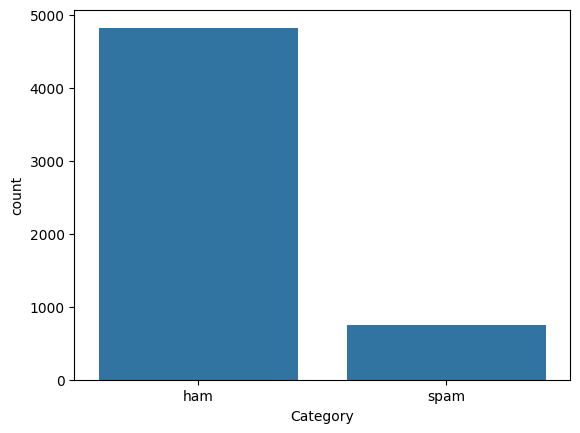

In [13]:
sns.countplot(x="Category", data=df) # validando se mudou as classes

In [15]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['Category'])

In [16]:
X = df['clean_text']
y = df['label_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#, stratify=y

In [17]:
#tokenização e padding
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

**LSTM**

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [19]:
# Definir o modelo LSTM
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(128, return_sequences=True))  # LSTM com retorno de sequências para atenção
model.add(AttentionLayer())  # Adicionar a camada de atenção
model.add(Dense(3, activation='softmax'))  # 3 saídas para sentimentos (negativo, neutro, positivo)

c:\Users\LUIRYS SILVA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [20]:
# Compilar o modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy se y_train for numérico
              metrics=['accuracy'])

In [21]:
# Treinar o modelo
history = model.fit(X_train_pad, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1)  # Validação durante o treinamento

Epoch 1/10


c:\Users\LUIRYS SILVA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:870: UserWarning: Gradients do not exist for variables ['sequential/attention_layer/att_u'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


126/126 ━━━━━━━━━━━━━━━━━━━━ 51s 361ms/step - accuracy: 0.8920 - loss: 0.3011 - val_accuracy: 0.9507 - val_loss: 0.1285
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 115s 619ms/step - accuracy: 0.9781 - loss: 0.0773 - val_accuracy: 0.9664 - val_loss: 0.1048
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 64s 466ms/step - accuracy: 0.9878 - loss: 0.0437 - val_accuracy: 0.9709 - val_loss: 0.1012
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 81s 452ms/step - accuracy: 0.9918 - loss: 0.0299 - val_accuracy: 0.9709 - val_loss: 0.1023
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 61s 488ms/step - accuracy: 0.9935 - loss: 0.0225 - val_accuracy: 0.9686 - val_loss: 0.1247
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 100s 622ms/step - accuracy: 0.9945 - loss: 0.0197 - val_accuracy: 0.9709 - val_loss: 0.1291
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 68s 498ms/step - accuracy: 0.9968 - loss: 0.0157 - val_accuracy: 0.9753 - val_loss: 0.1016
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 75s 439ms/step - accuracy: 0.9970 - loss: 0.0141 - v

**Métricas**

In [22]:
from sklearn.metrics import classification_report

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

# Gerar o relatório de classificação
print(classification_report(y_test, y_pred_classes))


35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 269ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.98      0.88      0.93       149

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [23]:
#acuracia,precisão, recall e f1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    return accuracy, precision, recall, f1
# Calcular as métricas
accuracy, precision, recall, f1 = calculate_metrics(y_test, y_pred_classes)
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Acurácia: 0.9812
Precisão: 0.9811
Recall: 0.9812
F1-Score: 0.9807


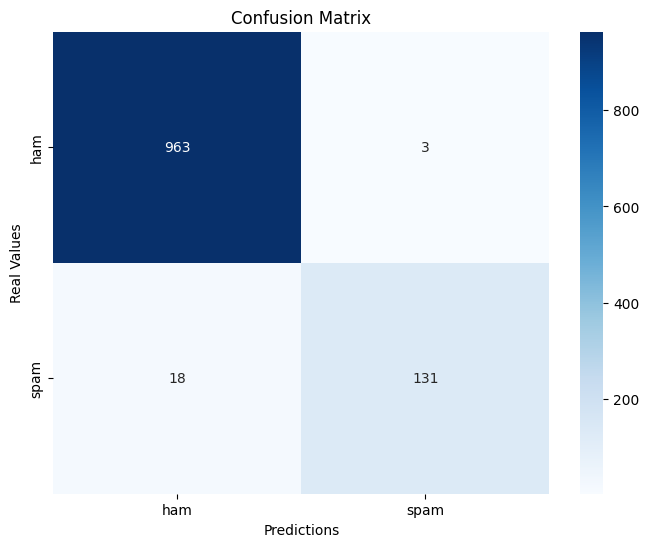

In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Criar o heatmap da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predictions")
plt.ylabel("Real Values")
plt.title("Confusion Matrix")
plt.show()

**LIME**

In [25]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=le.classes_)

def predict_proba(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len)
    predictions = model.predict(padded_sequences)
    return predictions  # Já retorna probabilidades (softmax)

# Solicita ao usuário o número da linha do exemplo
idx = int(input(f"Digite o número da linha (0 a {len(X_test)-1}): "))
sample_text = X_test.iloc[idx]
sample_label = y_test.iloc[idx]

# Predição da classe para o texto selecionado
sample_seq = tokenizer.texts_to_sequences([sample_text])
sample_pad = pad_sequences(sample_seq, maxlen=max_len)
pred_probs = model.predict(sample_pad)
pred_class_idx = pred_probs.argmax(axis=1)[0]
pred_class_name = le.classes_[pred_class_idx]

print(f"Número da linha no X_test: {idx}")
print(f"Original text:\n{sample_text}")
print(f"Classe real: {le.classes_[sample_label]}")
print(f"Classe predita: {pred_class_name}")

explanation = explainer.explain_instance(
    sample_text,
    predict_proba,
    num_features=10
)

print(explanation.as_list())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Número da linha no X_test: 51
Original text:
free st week nokia tone ur mob every week txt nokia get txting tell ur mate wwwgetzedcouk pobox w wq norm ptone
Classe real: spam
Classe predita: spam
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 189ms/step
[(np.str_('tone'), 0.11777872974869383), (np.str_('week'), 0.11001632707661958), (np.str_('free'), 0.10886306848886364), (np.str_('txt'), 0.10227661439929941), (np.str_('mob'), 0.07282386819232824), (np.str_('nokia'), 0.06455844049218668), (np.str_('st'), 0.05298504264751446), (np.str_('ur'), -0.0345748813262758), (np.str_('pobox'), 0.024759671414511648), (np.str_('w'), -0.016459269100896044)]


In [26]:
# Obtém as palavras mais importantes e seus pesos
lime_features = explanation.as_list()

# Exibe cada palavra com seu impacto na predição
print("Palavras mais importantes e seus pesos:")
for word, weight in lime_features:
    print(f"{word}: {weight:.4f}")

Palavras mais importantes e seus pesos:
tone: 0.1178
week: 0.1100
free: 0.1089
txt: 0.1023
mob: 0.0728
nokia: 0.0646
st: 0.0530
ur: -0.0346
pobox: 0.0248
w: -0.0165


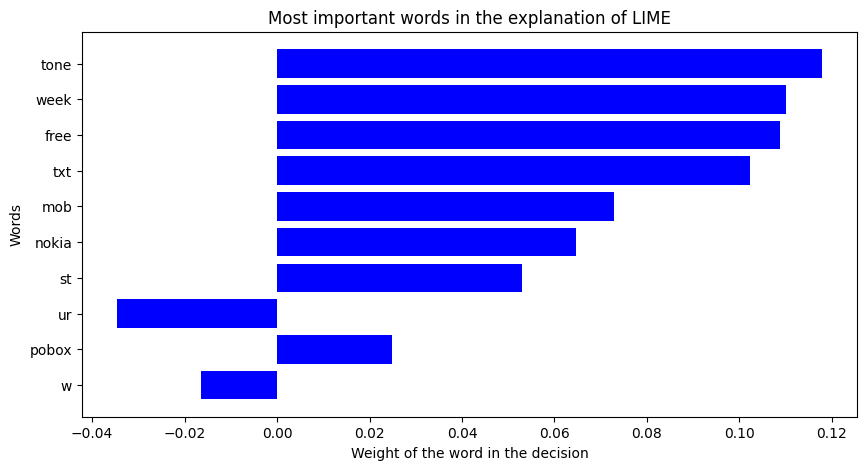

In [27]:
# Separar palavras e pesos
words, weights = zip(*lime_features)

# Criar gráfico de barras
plt.figure(figsize=(10, 5))
plt.barh(words, weights, color="blue")
plt.xlabel("Weight of the word in the decision")
plt.ylabel("Words")
plt.title("Most important words in the explanation of LIME")
plt.gca().invert_yaxis()  # Inverter para mostrar a palavra mais importante no topo
plt.show()

In [28]:
# Obter as palavras mais importantes e seus pesos no geral
words_weights = explanation.as_list()

# Imprimir as palavras e pesos
for word, weight in words_weights:
    print(f"{word}: {weight}")

tone: 0.11777872974869383
week: 0.11001632707661958
free: 0.10886306848886364
txt: 0.10227661439929941
mob: 0.07282386819232824
nokia: 0.06455844049218668
st: 0.05298504264751446
ur: -0.0345748813262758
pobox: 0.024759671414511648
w: -0.016459269100896044


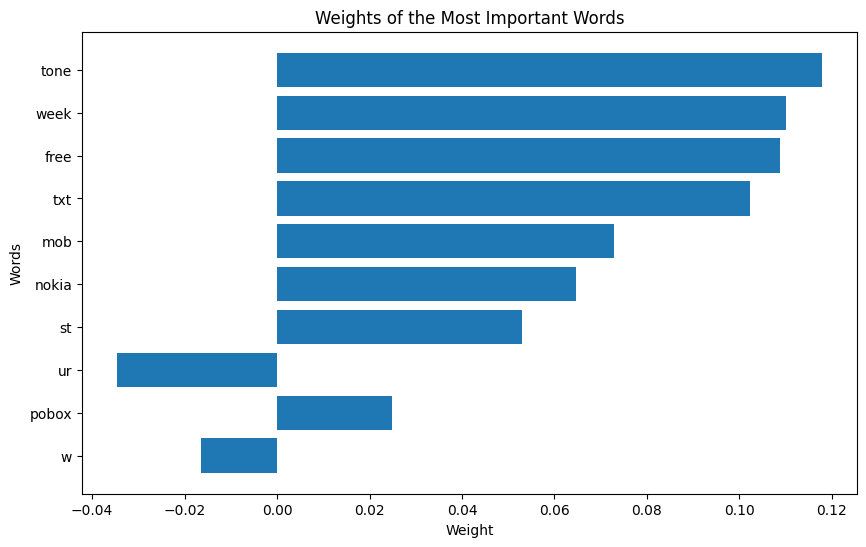

In [29]:
# Obter as palavras mais importantes e seus pesos no geral
words_weights = explanation.as_list()

# Separar palavras e pesos em listas separadas
words = [word for word, weight in words_weights]
weights = [weight for word, weight in words_weights]

# Criar o gráfico de barras horizontais
plt.figure(figsize=(10, 6))  # Ajustar o tamanho da figura, se necessário
plt.barh(words, weights)
plt.xlabel("Weight")
plt.ylabel("Words")
plt.title("Weights of the Most Important Words")
plt.gca().invert_yaxis()  # Inverter o eixo y para que as palavras mais importantes estejam no topo
plt.show()

**Attention Viz**

In [30]:
le.classes_

array(['ham', 'spam'], dtype=object)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
A classe prevista para o texto é o índice: 0

Palavras do exemplo e seus pesos na decisão da classe prevista (LSTM):
      Feature    Weight
3157  measure  0.092306
837      park -0.068112


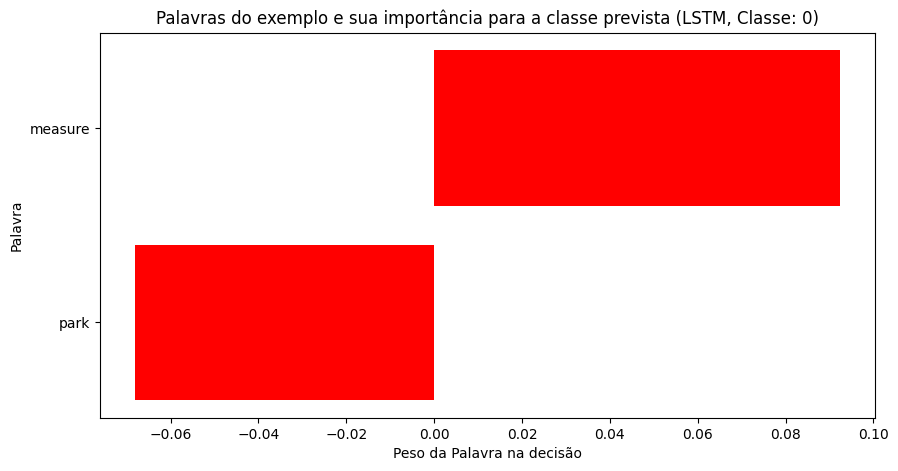

In [31]:
# Definir o texto de exemplo
sample_text = "preliminary estimation technology park measure square meter"

# **Etapa 1: Calcular a importância das palavras para cada classe do modelo LSTM**

# Obter os pesos da camada de Embedding
# Supondo que a camada de embedding é a primeira (índice 0)
embedding_weights = model.layers[0].get_weights()[0]

# Usar tokenizer.index_word para obter as palavras a partir dos índices
nomes_das_features = [tokenizer.index_word.get(i, '<OOV>') for i in range(1, embedding_weights.shape[0] + 1)]

# Obter os pesos da camada Dense (a última camada de saída)
dense_weights = model.layers[-1].get_weights()[0]

# Calcular a importância das palavras para cada classe
num_classes = dense_weights.shape[1]  # Número de classes de saída
importancias_das_features = []
for class_index in range(num_classes):
    # Obter os pesos da camada Dense para a classe atual
    class_weights = dense_weights[:, class_index]

    # Calcular a importância das palavras multiplicando os pesos da camada Dense pelos pesos da camada de Embedding
    word_importances = np.dot(embedding_weights, class_weights)

    importancias_da_classe = pd.DataFrame({'Feature': nomes_das_features, 'Weight': word_importances})
    importancias_da_classe = importancias_da_classe.sort_values(by='Weight', ascending=False)
    importancias_das_features.append(importancias_da_classe)

# **Etapa 2: Prever a classe do sample_text usando o modelo LSTM**

# O `maxlen` deve ser o mesmo usado durante o treinamento
# Assumindo que a variável `MAX_SEQUENCE_LENGTH` foi definida em uma célula anterior
# Caso contrário, defina-a aqui: MAX_SEQUENCE_LENGTH = ...
MAX_SEQUENCE_LENGTH = 100 # Substitua pelo valor correto do seu modelo

# Pré-processar o texto de exemplo para o modelo LSTM
sequence = tokenizer.texts_to_sequences([sample_text])
padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)

# Fazer a previsão
prediction = model.predict(padded_sequence)

# Obter o índice da classe prevista (a com maior probabilidade)
predicted_class_index = np.argmax(prediction[0])

print(f"A classe prevista para o texto é o índice: {predicted_class_index}")

# **Etapa 3: Visualizar a importância das palavras para a classe prevista**

# Selecionar o DataFrame de importâncias da classe prevista
importancias_da_classe_prevista = importancias_das_features[predicted_class_index]

# Criar um conjunto com as palavras do exemplo, para uma busca mais eficiente
# A regex `\b\w+\b` garante que apenas palavras sejam extraídas, ignorando pontuação
palavras_exemplo = set(re.findall(r'\b\w+\b', sample_text.lower()))

# Filtrar o DataFrame para incluir apenas as palavras que estão no texto de exemplo
importancias_exemplo_lstm = importancias_da_classe_prevista[
    importancias_da_classe_prevista['Feature'].apply(lambda x: x in palavras_exemplo)
]
importancias_exemplo_lstm = importancias_exemplo_lstm.sort_values(by='Weight', ascending=False)

# Exibir as importâncias das palavras do exemplo
print("\nPalavras do exemplo e seus pesos na decisão da classe prevista (LSTM):")
print(importancias_exemplo_lstm[['Feature', 'Weight']])

# **Etapa 4: Plotar o gráfico**

plt.figure(figsize=(10, 5))
plt.barh(importancias_exemplo_lstm['Feature'], importancias_exemplo_lstm['Weight'], color="red")
plt.xlabel("Peso da Palavra na decisão")
plt.ylabel("Palavra")
plt.title(f"Palavras do exemplo e sua importância para a classe prevista (LSTM, Classe: {predicted_class_index})")
plt.gca().invert_yaxis()
plt.show()

In [32]:
class_index = 0
class_weights = dense_weights[:, class_index]
word_importances = np.dot(embedding_weights, class_weights)
importancias_negativas = pd.DataFrame({'Feature': nomes_das_features, 'Weight': word_importances})
importancias_negativas = importancias_negativas.sort_values(by='Weight', ascending=False)

print("Most important features for the Negative class:")
print(importancias_negativas.head(20))

Most important features for the Negative class:
        Feature    Weight
1580      usual  0.269867
1887      shame  0.241183
1392      befor  0.232206
4839    stocked  0.227124
1416     looked  0.226051
3480      polyp  0.225796
33        sorry  0.219113
2047        ear  0.213807
31            r  0.206290
178       smile  0.204406
201        long  0.202775
286          wk  0.202651
1239    respond  0.202071
1896  lacsthere  0.198010
2689   tomocant  0.197506
804      result  0.195749
4905       pump  0.194739
2033   prabhaim  0.194726
43        later  0.193494
164        girl  0.193284


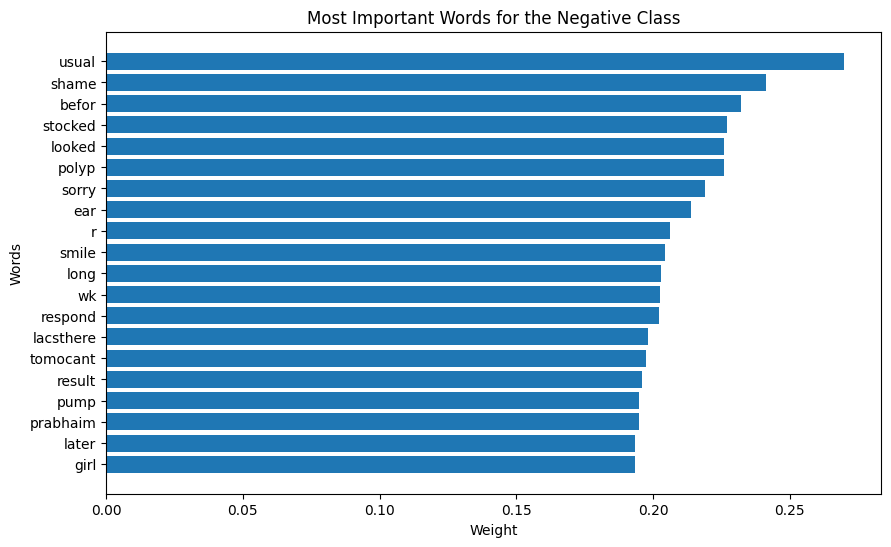

In [33]:
# Criar gráfico de barras para palavras negativas
plt.figure(figsize=(10, 6))
plt.barh(importancias_negativas['Feature'][:20], importancias_negativas['Weight'][:20])
plt.xlabel("Weight")
plt.ylabel("Words")
plt.title("Most Important Words for the Negative Class")
plt.gca().invert_yaxis()  # Inverter o eixo y para melhor visualização
plt.show()

In [34]:
class_index = 1
class_weights = dense_weights[:, class_index]
word_importances = np.dot(embedding_weights, class_weights)
importancias_neutras = pd.DataFrame({'Feature': nomes_das_features, 'Weight': word_importances})
importancias_neutras = importancias_neutras.sort_values(by='Weight', ascending=False)

print("Most important features for the Neutral class:")
print(importancias_neutras.head(20))

Most important features for the Neutral class:
                Feature    Weight
116           something  0.228200
4177            managed  0.220200
3131                 ph  0.220083
3315         stressfull  0.201712
1637              caken  0.199639
3214             sunoco  0.182002
1249        specialcall  0.180690
2863                mix  0.179937
666                hard  0.179763
1540              freak  0.179104
1199             affair  0.176316
3081           vomiting  0.174853
2432               fire  0.174614
2057  deliveredtomorrow  0.174178
2537            mailbox  0.173600
4427          developed  0.173437
194               lunch  0.172606
1903                 ne  0.172201
471               story  0.169726
4252            optical  0.169122


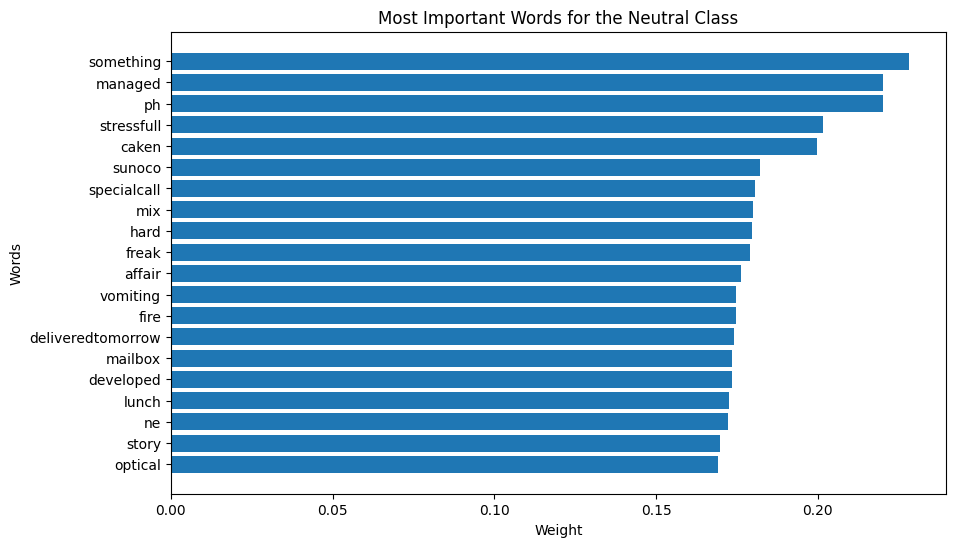

In [35]:
# Criar gráfico de barras para palavras neutras
plt.figure(figsize=(10, 6))
plt.barh(importancias_neutras['Feature'][:20], importancias_neutras['Weight'][:20])
plt.xlabel("Weight")
plt.ylabel("Words")
plt.title("Most Important Words for the Neutral Class")
plt.gca().invert_yaxis()  # Inverter o eixo y para melhor visualização
plt.show()

In [36]:
class_index = 2
class_weights = dense_weights[:, class_index]
word_importances = np.dot(embedding_weights, class_weights)
importancias_positivas = pd.DataFrame({'Feature': nomes_das_features, 'Weight': word_importances})
importancias_positivas = importancias_positivas.sort_values(by='Weight', ascending=False)

print("Most important features for the Positive class:")
print(importancias_positivas.head(20))

Most important features for the Positive class:
              Feature    Weight
0               <OOV>  1.104378
31                  r  0.212591
48               take  0.193448
1887            shame  0.189931
9                  ok  0.159330
1792           strong  0.157501
164              girl  0.154499
4384              hui  0.150295
365             music  0.149216
178             smile  0.146192
2724          airport  0.143745
1410             pple  0.143183
2484  lucozadecoukwrc  0.142308
655           invited  0.141581
1995               mk  0.141481
1377        videochat  0.140341
455            double  0.139709
562             paper  0.139126
710                an  0.137890
1598         tenerife  0.137710


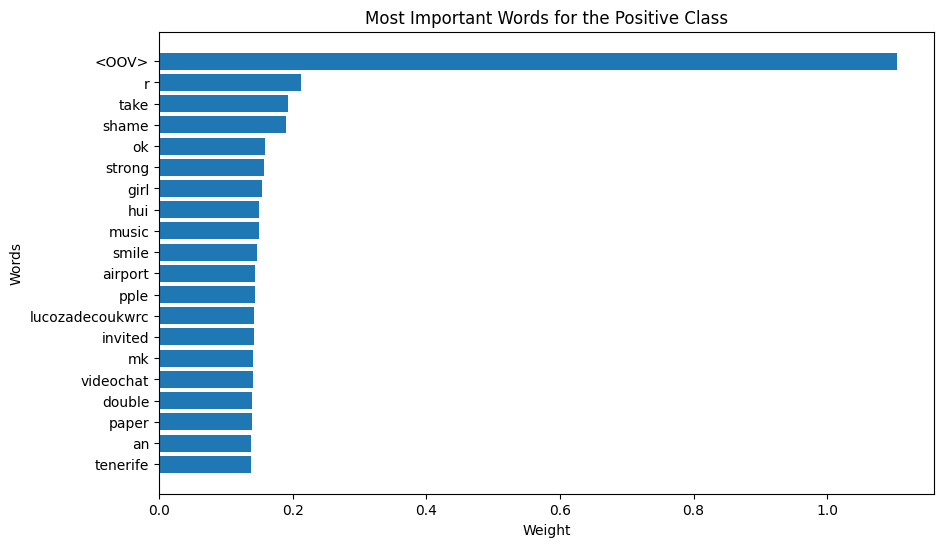

In [37]:
# Criar gráfico de barras para palavras positivas
plt.figure(figsize=(10, 6))
plt.barh(importancias_positivas['Feature'][:20], importancias_positivas['Weight'][:20])
plt.xlabel("Weight")
plt.ylabel("Words")
plt.title("Most Important Words for the Positive Class")
plt.gca().invert_yaxis()  # Inverter o eixo y para melhor visualização
plt.show()